HMC with https://colab.research.google.com/drive/1YQBSfS1Nb8a9TAMsV1RjWsiErWqXLbrj#scrollTo=FqU8oNOCTcdL

Hamiltonian Monte Carlo is a variant of MH, but the proposal distribution adds more complexity. MH uses random walks to explore the probability space; as discussed, the likelihoods of current and proposed locations are compared for movement criteria. However, as dimensionality increases, the high likelihood region(s) composes (exponentially) less and less of the total area. In these cases, MH cannot efficiently explore all regions of the distribution and might return samples that are not truly representative of the distribution's shape.

HMC instead designs a scheme by which the size of the jump is proportionate to the (negative log) likelihood of the sampler's current position. When close to the high likelihood region(s), it proposes nearby positions; conversely, when far from these high likelihood region(s), larger jumps are proposed. The key is relating position to leap size.

HMC loosely uses Hamiltonian mechanics to inform these jumps; namely, differential equations relating position and momentum to each other. Often, differential equations cannot be solved exactly, however various symplectic integration methods (such as leapfrog integration) can closely approximate the solution. These (differential) equations are: (A) the gradient of position with respect to time and (B) the gradient of momentum with respect to time. Leapfrog integration iteratively updates position and momentum in order to estimate where a particle will be given its current position and momentum.

Variables and gradients are as follows:

Q = position (parameters in bayes analogy)
P = momentum 
V = potential energy
K = kinetic energy
T = times
dQ/dT = P # position wrt time equals momentum
dP/dT = -dV/dQ # momentum wrt time equals potential energy wrt position

Of note, position is updated by momentum, and momentum is updated by the change in potential energy wrt position. In our context, position means the specific input variable, x, in the neagtive log PDF. When the position is approaching the high likelihood region(s), the slope is near 0. But when far from said region(s), the slope is much steeper. The effect is that positions corresponding to moderate and low likelihoods experience a large gradient in the direction of the highest likelihood region(s). This has the beneficial effect of taking big jumps when exploring moderate/low likelihood regions (most of the distribution) but small jumps when exploring high likelihood region(s). Refer to above graphics to conceptually consider why this might be beneficial.

The negative log PDF is used for multiple reasons: First, (in the context of the univariate gaussian) the log function undoes exponentiation, resulting in a parabolla; this means the slope becomes increaseingly steeper with distance from the expectation (no inflection points, tail slopes don't approach 0). Second, logarithms tend to limit the risk of numerical underflow and overflow. And third, logarithms tend to simplify differentiation, resulting in a less complex functions, which are easier to derive.

As discussed in graphics above, if the step size and integration length are well tuned to the current position, the ball will roll down the bowl and back up to the same height on the opposing side; however, the sampler proposes new positions at the end of the integration period, not at intermediary steps in between; this has the effect of bouncing between positions at (or near) the same likelihood. In order to explore other likelihoods, a random increase or decrease in momentum is needed.

These "momentum kicks" take the form of the proposal distribution in the familiar context of the MH algorithm. A kick is sampled, leapfrog integration uses hamiltonian mechanics to determine how far the sampler will "travel" (given a fixed integration interval.) It might not be obvious, but the proposal distribution is not yet symmeytric. If a ball rolls down the parabolla, it starts in a high position with high potential energy but low kinetic energy. As it rolls down the curve, it now has high kinetic energy but low potential energy. If the kinetic energy were to be spontaneously reversed, it would ensure that the ball would travel from point B, at the bottom of the parabolla, back up to its starting position, point A. And this correction of "flipping" the momentum ensures proposal distribution symmetry.

In other words, to correct for the assymetric proposal distrbiution, the starting position and starting momentum is taken and compared to the ending position and negative ending kinetic energy, such that the motion could be reversed. With this correction, the sampler now behaves as though it had a symmetric proposal distribution. The math in the code below appears a bit tricky but this is solely due to the use of negative logarithms (ie division becomes subtraction, multiplication becomes addition and due to the negative log, the signs are reversed.)

Inm previous sections, the exponential distribution was sampled using the beta distribution and the "hastings ratio" was computed to correct for the assyemtric distribution. Study this concept to better understand the hastings ratio in the context of HMC.

Of note, the step size and integration length variables in the code below inform the HMC sampler for how long to travel given some starting momentum and position. In general, it is very difficult to "tune the proposal distribution", meaning find a step size and integration length that suits generally any position/likelihood, which the sampler might explore.

The slightest change to these variables can negatively affect HMC performance. For example, the hypothetical ball could start on the negative log gaussian slope above, roll all the ways to the top of the other side, and back again to the original position. This is known as a "U-turn" and is the basis for the aptly named "No U-Turn Sampler" or NUTS. In practice, there are no "one size fits all" step size and path length parameters. As such, NUTS is more common in practice than HMC.

Disclaimer: All these were copied from the blog in the given link.

Let's look at the implementation and try to understand what all is happening.

In [1]:
import numpy as np
import random
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# Define the normal pdf for a single value(I think could be a vector as well) as follows
def normal(x,mu,sigma):
    numerator = np.exp(-1*((x-mu)**2)/(2*sigma**2))
    denominator = sigma * np.sqrt(2*np.pi)
    return numerator/denominator

In [3]:
# negative log pdf
def neg_log_prob(x,mu,sigma):
    return -1*np.log(normal(x=x,mu=mu,sigma=sigma)) # note this normal is coming from the earlier function

In [12]:
# Define the hmc function
def HMC(mu = 0.1, sigma = 1.0, path_len = 1, step_size = 0.25, initial_position = 0.0, epochs = 1000):
    # mu, sigma for teh normal pdf above
    # what is path_len though?
    # step_size is step size for the algorithm
    # initial_position - initial value of x?
    # path_len is L? no.of steps?
    # epochs is the number of times to run the insides of L? No idea, understand this.

    # setup
    steps = int(path_len/step_size) # why is this necessary though, we read this in chapter 5 too, that this needs to be an integer. 
    samples = [initial_position] # this is where we will keep track of the parameter, this is what we are going to update - and then do accept/reject.
    momentum_dist = st.norm(0, 1) # this is for the momentum, this will instantiate a standard normal distribution frrom which samples will be drawn later for the momentum variable

    # generate samples
    for i in range(epochs):
        # get the current value 
        q0 = np.copy(samples[-1])
        # copy the curent value as q1 - why though?
        q1 = np.copy(q0)
        # sample p0 from the specified dsitribtution
        p0 = momentum_dist.rvs()
        # p1 is the same as p0? - why?
        p1 = np.copy(p0)
        # get the derivative 
        dVdQ = -1*(q0 - mu)/(sigma**2)


        # leap frog integration
        for j in range(steps):
            p1 += step_size*dVdQ/2 # as potential energy increases, kinetic energy decreases, half-step
            q1 += step_size*p1 # position increases as function of momentum 
            new_dVdQ = - 1*(q1 - mu)/(sigma**2)
            p1 += step_size*new_dVdQ/2 # second half-step "leapfrog" update to momentum
        # leapfrog integration end        
        p1 = -1*p1 #flip momentum for reversibility

        #metropolis acceptance
        q0_nlp = neg_log_prob(x=q0,mu=mu,sigma=sigma)
        q1_nlp = neg_log_prob(x=q1,mu=mu,sigma=sigma)        

        p0_nlp = neg_log_prob(x=p0,mu=0,sigma=1)
        p1_nlp = neg_log_prob(x=p1,mu=0,sigma=1)

        # Account for negatives AND log(probabiltiies)...
        target = q0_nlp - q1_nlp # P(q1)/P(q0)
        adjustment = p1_nlp - p0_nlp # P(p0)/P(p1)
        acceptance = target + adjustment # [P(q1)*P(p0)]/[P(q0)*P(p1)] 
        
        event = np.log(random.uniform(0,1))
        if event <= acceptance:
            samples.append(q1)
        else:
            samples.append(q0)
    
    return samples

In [13]:
mu = 0
sigma = 1
trial = HMC(mu=mu,sigma=sigma,path_len=1.5,step_size=0.25) #note the step_size and path_len parameters

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

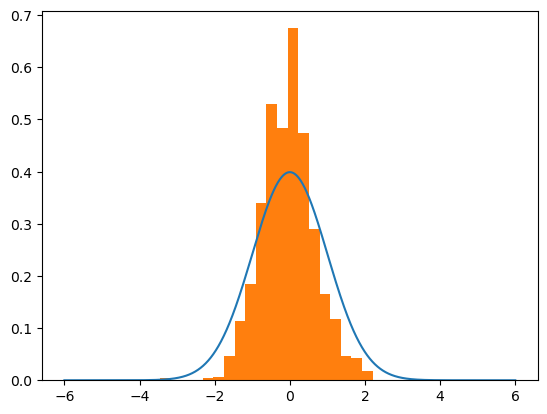

In [14]:
plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=20)
plt.show()

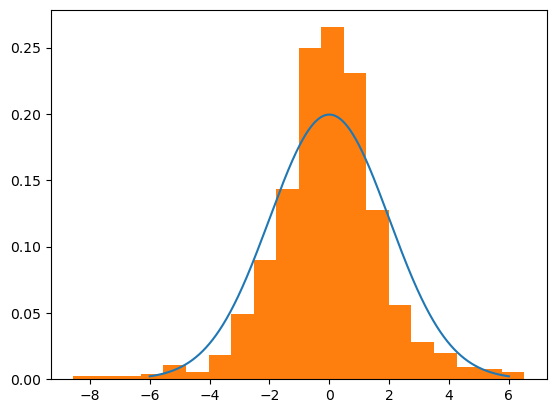

In [19]:
mu = 0
sigma = 2
trial = HMC(mu=mu,sigma=sigma,path_len=4,step_size=0.5) #note the change in step_size and path_len parameters...

lines = np.linspace(-6,6,10_000)
normal_curve = [normal(x=l,mu=mu,sigma=sigma) for l in lines]

plt.plot(lines,normal_curve)
plt.hist(trial,density=True,bins=20)
plt.show()

We are ready for Hamiltonian Monte Carlo methods. We need to specifically understand the NUTs sampler. The following code is from ChapGPT for the implementation of HMC methods. 

In [8]:
import numpy as np

In [9]:
# Define the target distribution (e.g., a standard Gaussian)
def target_log_prob(x):
    return -0.5 * np.sum(x**2)

# Gradient of the target log-probability
def grad_log_prob(x):
    return -x

# Leapfrog integrator
def leapfrog(x, p, step_size, num_steps):
    x_new = np.copy(x)
    p_new = np.copy(p)
    
    # Half step for momentum at the beginning
    p_new -= 0.5 * step_size * grad_log_prob(x_new)
    
    # Full step for position
    for _ in range(num_steps):
        x_new += step_size * p_new
        # Full step for momentum (except last iteration)
        if _ != num_steps - 1:
            p_new -= step_size * grad_log_prob(x_new)
    
    # Half step for momentum at the end
    p_new -= 0.5 * step_size * grad_log_prob(x_new)
    
    return x_new, p_new

# Hamiltonian function (H = Kinetic + Potential)
def hamiltonian(x, p):
    kinetic = 0.5 * np.sum(p**2)  # Kinetic energy from momentum (Gaussian)
    potential = -target_log_prob(x)  # Potential energy from target distribution
    return kinetic + potential

# HMC sampler
def hmc_sampler(init_x, step_size, num_steps, num_samples):
    samples = []
    x = np.copy(init_x)
    
    for _ in range(num_samples):
        # Sample momentum from standard normal
        p = np.random.randn(*x.shape)
        
        # Save the current state
        current_x = np.copy(x)
        current_p = np.copy(p)
        
        # Perform leapfrog integration
        new_x, new_p = leapfrog(x, p, step_size, num_steps)
        
        # Calculate Hamiltonians
        current_H = hamiltonian(current_x, current_p)
        new_H = hamiltonian(new_x, new_p)
        
        # Metropolis-Hastings correction
        if np.random.rand() < np.exp(current_H - new_H):
            x = new_x  # Accept the new state
        # else: reject and keep the current state
        
        samples.append(np.copy(x))
    
    return np.array(samples)



In [10]:
# Parameters
init_x = np.array([0.0])  # Initial position
step_size = 0.1  # Step size for leapfrog
num_steps = 10  # Number of leapfrog steps
num_samples = 1000  # Number of samples to generate

# Run HMC
samples = hmc_sampler(init_x, step_size, num_steps, num_samples)

# Print the first few samples
print(samples[:10])

[[ 0.78329214]
 [ 0.76241562]
 [ 0.06407853]
 [-0.27938608]
 [-1.04174926]
 [-1.04174926]
 [-1.51202876]
 [-1.51202876]
 [-1.51202876]
 [-1.51202876]]


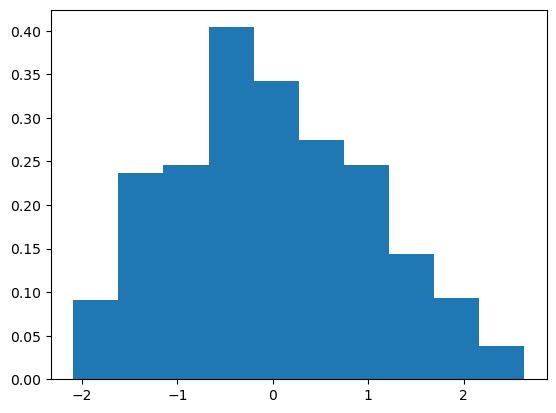

In [11]:

plt.hist(samples,density=True)
plt.show()